Demonstrates Roq's new simulator

In [1]:
import os
import datetime

import matplotlib as mpl

import pandas as pd

import roq

This is the configuration

In [2]:
SETTINGS = roq.client.Settings2(
    app={
        "name": "trader",
    },
    loop={
        "timer_freq": datetime.timedelta(milliseconds=100),
    },
    service={},
    common={},
)


CONFIG = roq.algo.strategy.Config(
    legs=[
        roq.algo.Leg(
            source=0,
            account="A1",
            exchange="deribit",
            symbol="BTC-PERPETUAL",
            time_in_force=roq.TimeInForce.GTC,
        ),
        roq.algo.Leg(
            source=1,
            account="A1",
            exchange="bybit",
            symbol="BTCUSD",
        ),
    ],
    strategy_id=123,
)


def create_strategy(dispatcher, order_cache, config):
    return roq.algo.strategy.create(
        type=roq.algo.strategy.Type.ARBITRAGE,
        dispatcher=dispatcher,
        order_cache=order_cache,
        config=config,
        parameters="max_age=10s;threshold=5;quantity_0=1;min_position_0=-5;max_position_0=5",
    )


def create_reporter():
    return roq.algo.reporter.create(
        type=roq.algo.reporter.Type.SUMMARY,
    )


def create_matcher(dispatcher, order_cache, config):
    return roq.algo.matcher.create(
        type=roq.algo.matcher.Type.SIMPLE,
        dispatcher=dispatcher,
        order_cache=order_cache,
        config=config,
    )


FACTORY = roq.algo.Factory(
    create_strategy=create_strategy,
    create_reporter=create_reporter,
    create_matcher=create_matcher,
)


PARAMETERS = [
    "{HOME}/var/lib/roq/data/deribit-public.roq".format(**os.environ),
    "{HOME}/var/lib/roq/data/bybit-public.roq".format(**os.environ),
]

Now we launch the simulator

The simulator will create an instance of a reporter to collect data during the simulation run

The simulator will create a single strategy and manage the life-time of it (to avoid inadverently re-using state on subsequent simulation runs)

The simulator will dynamically create matching engines as they are needed

In [3]:
# %%timeit -n 1 -r 1
reporter = roq.client.Simulator2.dispatch(
    settings=SETTINGS,
    factory=FACTORY,
    config=CONFIG,
    parameters=PARAMETERS,
)

L0 simple.cpp:100] [0:deribit] connected
L0 simple.cpp:100] [1:bybit] connected
L0 simple.cpp:127] [0:deribit] ready
L0 simple.cpp:127] [1:bybit] ready
L0 simple.cpp:106] [0:deribit] disconnected
L0 simple.cpp:106] [1:bybit] disconnected


The reporter may hold collected data (depending on the "type")

Here we extract some "history"

In [4]:
result = reporter.extract("history")
# print(result)

The result now holds data and index information, enough to create a Pandas DataFrame

In [5]:
df = pd.DataFrame(result["data"]).set_index(result["index"])
df

best_bid_price  \
source exchange symbol        sample_period_utc                     
0      deribit  BTC-PERPETUAL 1730473620000000000         71145.5   
                              1730473680000000000         71107.5   
                              1730473740000000000         70975.0   
                              1730473800000000000         70941.5   
                              1730473860000000000         70938.0   
...                                                           ...   
1      bybit    BTCUSD        1730476680000000000         69465.5   
                              1730476740000000000         69369.5   
                              1730476800000000000         69412.0   
                              1730476860000000000         69558.0   
                              1730476920000000000         69508.0   

                                                   best_ask_price  buy_volume  \
source exchange symbol        sample_period_utc                                 
0      deribit  BTC-PERPETUAL 1730473620000000000         71146.0         0.0   
                              1730473680000000000         71108.0        17.0   
                              1730473740000000000         70975.5        22.0   
                              1730473800000000000         70942.0        42.0   
                              1730473860000000000         70938.5        58.0   
...                                                           ...         ...   
1      bybit    BTCUSD        1730476680000000000         69466.0      1022.0   
                              1730476740000000000         69370.0      1088.0   
                              1730476800000000000         69412.5      1192.0   
                              1730476860000000000         69558.5      1254.0   
                              1730476920000000000         69508.5      1309.0   

                                                   sell_volume  position  \
source exchange symbol        sample_period_utc                            
0      deribit  BTC-PERPETUAL 1730473620000000000          6.0      -6.0   
                              1730473680000000000         23.0      -6.0   
                              1730473740000000000         28.0      -6.0   
                              1730473800000000000         48.0      -6.0   
                              1730473860000000000         64.0      -6.0   
...                                                        ...       ...   
1      bybit    BTCUSD        1730476680000000000       1026.0      -4.0   
                              1730476740000000000       1092.0      -4.0   
                              1730476800000000000       1186.0       6.0   
                              1730476860000000000       1258.0      -4.0   
                              1730476920000000000       1303.0       6.0   

                                                   average_price  mark_price  \
source exchange symbol        sample_period_utc                                
0      deribit  BTC-PERPETUAL 1730473620000000000   71142.000000     71146.0   
                              1730473680000000000   71144.000000     71108.0   
                              1730473740000000000   71142.250000     70975.5   
                              1730473800000000000   70938.500000     70942.0   
                              1730473860000000000   70955.083333     70938.5   
...                                                          ...         ...   
1      bybit    BTCUSD        1730476680000000000   69454.500000     69466.0   
                              1730476740000000000   69361.750000     69370.0   
                              1730476800000000000   69412.500000     69412.0   
                              1730476860000000000   69498.500000     69558.5   
                              1730476920000000000   69508.500000     69508.0   

                                                   unrealized_profit 

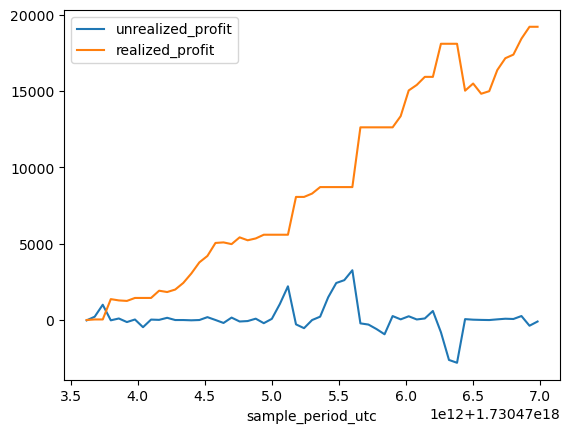

In [6]:
_ = df.loc[(0,'deribit','BTC-PERPETUAL')][['unrealized_profit','realized_profit']].plot()

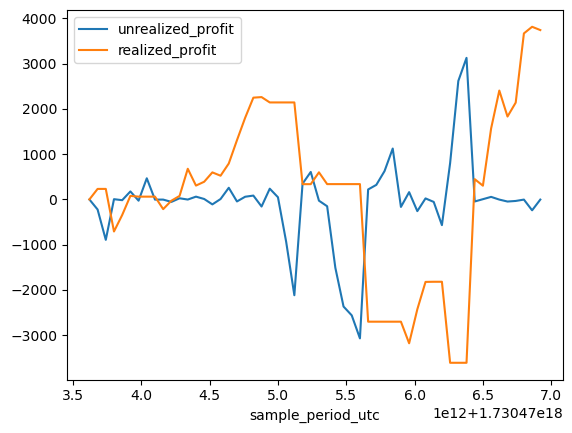

In [7]:
_ = df.loc[(1,'bybit','BTCUSD')][['unrealized_profit','realized_profit']].plot()